In [3]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# [기본실험] LMS 노드 학습 내용에 맞추어 훈련 진행

## CIFAR-10 데이터 준비하기

In [4]:
# CIFAR-10 데이터 로드
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

### 특정 레이블 데이터셋만 로드하는 경우

In [5]:
import pandas as pd

# 학습 시간을 줄이기 위해 한 종류의 레이블만 로드하기
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])

    return train_x, test_x

In [6]:
train_x, test_x = load_data(label=1)    # 1: automobile 데이터만 로드

In [7]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [8]:
# 데이터 정규화하기: 0 부터 255 사이의 값 --> -1 부터 1 사이로 정규화
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [9]:
train_x.shape

(5000, 32, 32, 3)

In [10]:
test_x.shape

(1000, 32, 32, 3)

In [11]:
# 부동소수점 타입으로 변환
# train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x = train_x.astype('float32')
train_x.shape

(5000, 32, 32, 3)

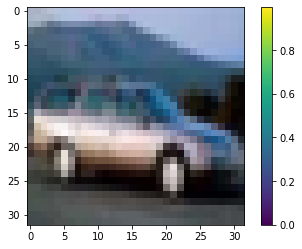

In [12]:
# 첫번째 데이터 표시하기
# -1 부터 1 사이의 값을 matplotlib를 사용해 화면에 표시할 때는 0 부터 1 사이의 값으로 변환한 뒤에 표시
plt.imshow((train_x[0] + 1) / 2)
plt.colorbar()
plt.show()

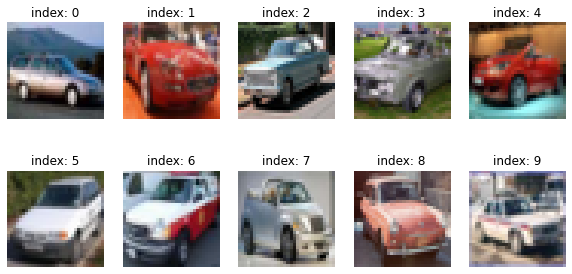

In [13]:
# 샘플 10개 표시하기
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    # -1 부터 1 사이의 값을 matplotlib를 사용해 화면에 표시할 때는 0 부터 1 사이의 값으로 변환한 뒤에 표시
    plt.imshow((train_x[i] + 1) / 2)
    plt.title(f'index: {i}')
    plt.axis('off')
    
plt.show()

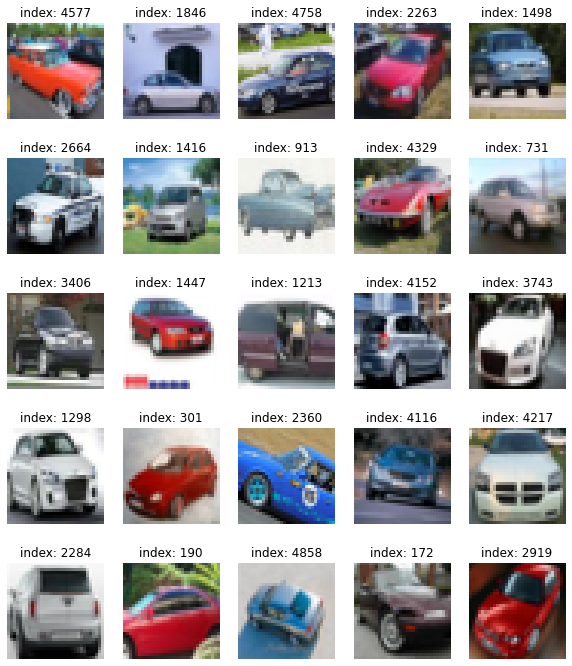

In [14]:
# 50,000개 샘플 중에서 임의로 25개 뽑아서 표시하기
import numpy as np

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_number = np.random.randint(0, 5000)
#     random_number = np.random.randint(0, 50000)
    # -1 부터 1 사이의 값을 matplotlib를 사용해 화면에 표시할 때는 0 부터 1 사이의 값으로 변환한 뒤에 표시
    plt.imshow((train_x[random_number] + 1) / 2)
    plt.title(f'index: {random_number}')
    plt.axis('off')

plt.show()

In [15]:
# tf.data.Dataset으로 변환
BUFFER_SIZE = 5000
# BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자(Generator) 만들기

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [17]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### [테스트] 임의의 랜덤 노이즈로부터 이미지 생성해 보기

In [18]:
noise = tf.random.normal([1, 100])

In [19]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.5444916e+00,  1.4099654e+00,  1.5694016e+00, -8.8969126e-02,
        -1.1855752e+00,  1.1557899e+00,  1.0508443e+00, -3.9001688e-01,
        -8.4488326e-01, -1.5809617e+00,  4.4219482e-01, -1.2565610e-01,
         3.6802617e-01, -3.2071877e-02,  9.6546340e-01, -2.8242288e+00,
         3.1639466e-01, -5.5119693e-01,  8.1919420e-01,  1.6427559e+00,
        -6.9612563e-01,  9.4352508e-01,  1.0642824e+00, -2.2383780e+00,
         2.1973972e+00,  9.6105468e-01, -2.4946529e-01,  1.2498733e+00,
         1.4488368e+00,  7.3463243e-01,  1.7536662e+00, -8.2537675e-01,
         2.0193543e+00, -4.9062435e-02, -8.5078830e-01, -2.1420391e+00,
         1.2141238e+00,  1.5477093e+00,  3.9323834e-01, -1.7004901e+00,
        -1.1920006e+00,  2.5313145e-01, -3.4236491e-01, -1.5168164e+00,
         1.7622460e+00, -6.7904872e-01, -5.1321381e-01, -9.6285117e-01,
        -9.1705233e-01,  1.0621003e-01,  7.3891848e-02, -5.0158322e-01,
        -6.310

In [20]:
# 훈련 과정이 아닌 추론 과정이므로 training=False로 지정해야 함!
# 특히, 생성자 모델에 포함된 BatchNormalization 레이어는 훈련 과정과 추론 과정에서의 동작이 다름!!
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

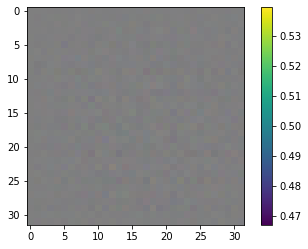

In [21]:
# 생성된 이미지 표시해 보기: 훈련이 진행되기 전 임의의 노이즈로부터 생성된 이미지이므로 사실 아무 의미없는 이미지이긴 함. 
plt.imshow((generated_image[0] + 1) / 2)
plt.colorbar()
plt.show()

## 판별자(Discriminator) 만들기

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [23]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### 앞에서 임의의 노이즈로부터 생성했던 가짜 이미지 판별해 보기
- 사실 이 판별값 역시 아무 의미 없긴 함. 

In [24]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00403382]], dtype=float32)>

## 손실함수와 최적화 함수 정의하기

### 손실함수(Loss function) 정의하기

In [25]:
"""
우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠.
그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 (참고). 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.
"""
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [27]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.zeros_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[0, 0, 0],
       [0, 0, 0]], dtype=int32)>

In [28]:
"""
generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.
"""
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
"""
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!

최종 discriminator_loss 값은 이 둘을 더한 값입니다.
"""
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [30]:
"""
한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.
"""
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(Optimizer) 정의하기

In [31]:
"""
Adam 함수 또한 tf.keras.optimizers 안에 있습니다.
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.

또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.
"""
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Seed 노이즈 생성해 두기

In [32]:
"""
샘플은 한 번에 16장을 생성하도록 하겠습니다.
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.
"""
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련하기

In [33]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [34]:
# 이미지 생성하고 matplotlib로 한꺼번에 표시한 이미지 저장하기
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) /2)
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
#     plt.savefig('./data/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
#                     .format(epoch, it))

    plt.show()

In [35]:
# 훈련 중 그래프 그리고 해당 이미지도 저장하기
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
#     plt.savefig('./data/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
#                     .format(epoch))

    plt.show()

In [36]:
# 훈련 중 체크포인트도 저장해 두기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'
# checkpoint_dir = './data/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [37]:
# 훈련 함수 정의
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 5 == 0:
#             if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [38]:
save_every = 5
EPOCHS = 200
# save_every = 2
# EPOCHS = 2

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### [선택] 미리 저장해 둔 체크포인트 로드해서 해당 시점부터 다시 훈련 진행하기

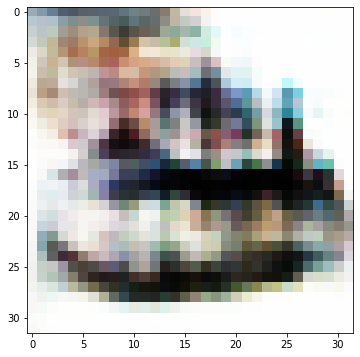

In [39]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

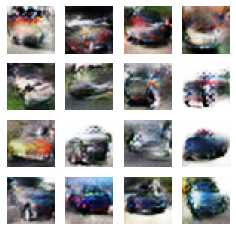

Time for training : 931 sec


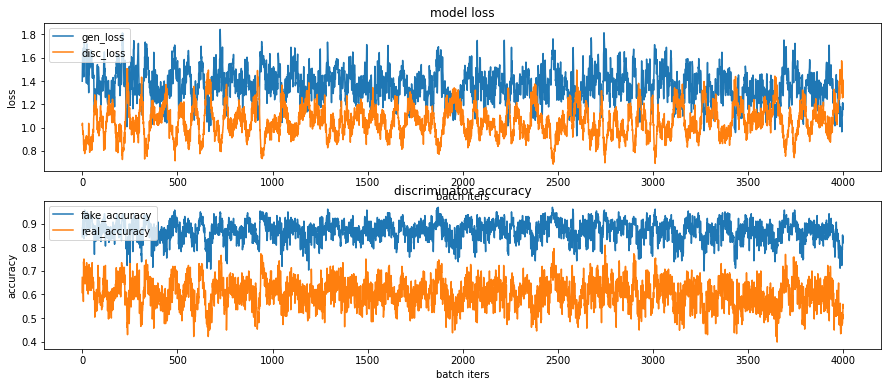

CPU times: user 17min 13s, sys: 3min 8s, total: 20min 22s
Wall time: 15min 31s


In [45]:
%%time
train(train_dataset, EPOCHS, save_every)
# 학습과정의 loss, accuracy 그래프 이미지 파일이 ./data/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 학습 과정 시각화하기

In [46]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'
# anim_file = './data/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
#     filenames = glob.glob('./data/dcgan_newimage/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# !ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

# [추가실험] 커널 사이즈를 (5,5) --> (4,4)로 변경해 훈련 진행
- 생성자와 판별자의 커널 사이즈를 (5,5)에서 (4,4)로 변경
- 활성함수 LeakyReLU 레이어에 alpha=0.2 추가
- 생성자에서 BatchNormalization 레이어 제거
- 생성자에서 Conv2DTranspose 레이어의 차원 증가
- 판별자에서 Conv2D 레이어마다 추가했던 Dropout 레이어를 Flatten 레이어 다음에 한 번만 적용하고 비율도 0.3에서 0.2로 변경

## 생성자(Generator) 만들기

In [64]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 128)))
    assert model.output_shape == (None, 8, 8, 128) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 256)
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (5, 5), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [65]:
generator = make_generator_model()

generator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8192)              819200    
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 16, 16, 128)       262144    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 32, 32, 256)       524288    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 32, 32, 3)        

### [테스트] 임의의 랜덤 노이즈로부터 이미지 생성해 보기

In [66]:
noise = tf.random.normal([1, 100])

In [67]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.8914964 ,  0.513495  ,  1.5316288 , -1.4411738 ,  0.44108424,
        -1.6443869 ,  0.28005862,  0.6394627 ,  0.11942907, -1.3803757 ,
         0.9811197 , -1.2022771 , -1.4718896 ,  1.5564992 , -0.74786276,
        -0.34926602, -0.71128196,  0.25031543,  0.9178372 , -1.9458047 ,
        -0.50499815, -1.9350784 ,  0.12863408,  0.82428765,  1.313738  ,
        -0.8441619 ,  0.32770362,  0.26676816, -0.2197036 , -1.190839  ,
         0.4377342 , -1.2616438 , -0.27376747,  0.6463899 , -0.31247196,
         0.25731456, -0.8893455 , -0.96643794,  0.7967072 , -0.65867764,
        -0.21411318, -0.54475796,  0.36672437,  0.10250285,  0.30961537,
         0.0044376 ,  0.2049057 , -1.2972267 , -0.29538584, -1.6463349 ,
        -1.0103384 , -0.6179688 , -2.4632277 , -0.20168953, -1.4739888 ,
        -0.56679904,  0.8808511 ,  0.91556776, -1.1790857 ,  0.12567444,
        -0.46112344,  0.9626672 ,  1.3995159 ,  1.2382185 ,  0.5933413 ,
 

In [68]:
# 훈련 과정이 아닌 추론 과정이므로 training=False로 지정해야 함!
# 특히, 생성자 모델에 포함된 BatchNormalization 레이어는 훈련 과정과 추론 과정에서의 동작이 다름!!
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

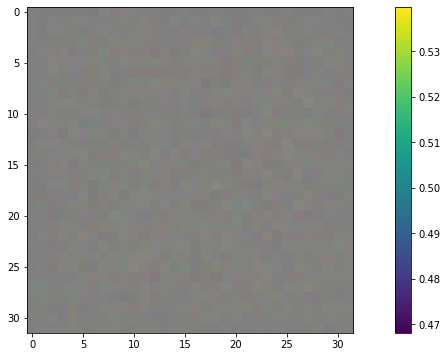

In [69]:
# 생성된 이미지 표시해 보기: 훈련이 진행되기 전 임의의 노이즈로부터 생성된 이미지이므로 사실 아무 의미없는 이미지이긴 함. 
plt.imshow((generated_image[0] + 1) / 2)
plt.colorbar()
plt.show()

## 판별자(Discriminator) 만들기

In [70]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))    # 중요!
    model.add(layers.Dense(1))

    return model

In [71]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

### 앞에서 임의의 노이즈로부터 생성했던 가짜 이미지 판별해 보기
- 사실 이 판별값 역시 아무 의미 없긴 함. 

In [72]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00451413]], dtype=float32)>

## 손실함수와 최적화 함수 정의하기

### 손실함수(Loss function) 정의하기

In [73]:
"""
우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠.
그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 (참고). 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.
"""
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [74]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [75]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.zeros_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[0, 0, 0],
       [0, 0, 0]], dtype=int32)>

In [76]:
"""
generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.
"""
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [77]:
"""
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!

최종 discriminator_loss 값은 이 둘을 더한 값입니다.
"""
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [78]:
"""
한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.
"""
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(Optimizer) 정의하기

In [79]:
"""
Adam 함수 또한 tf.keras.optimizers 안에 있습니다.
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.

또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.
"""
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Seed 노이즈 생성해 두기

In [80]:
"""
샘플은 한 번에 16장을 생성하도록 하겠습니다.
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.
"""
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련하기

In [81]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [82]:
# 이미지 생성하고 matplotlib로 한꺼번에 표시한 이미지 저장하기
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) /2)
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
#     plt.savefig('./data/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
#                     .format(epoch, it))

    plt.show()

In [83]:
# 훈련 중 그래프 그리고 해당 이미지도 저장하기
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history2/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
#     plt.savefig('./data/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
#                     .format(epoch))

    plt.show()

In [84]:
# 훈련 중 체크포인트도 저장해 두기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints2'
# checkpoint_dir = './data/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [85]:
# 훈련 함수 정의
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 5 == 0:
#             if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [86]:
save_every = 5
EPOCHS = 1000
# save_every = 2
# EPOCHS = 2

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

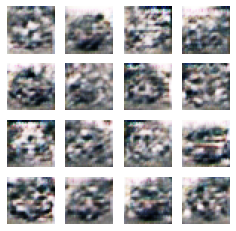

Time for training : 6258 sec


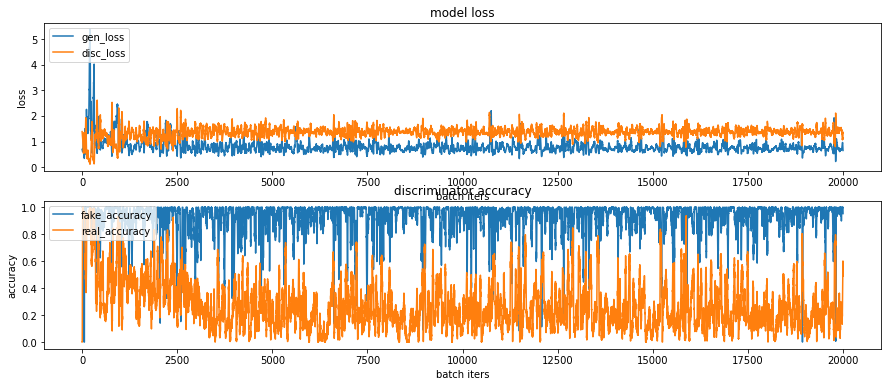

CPU times: user 1h 52min 22s, sys: 15min 41s, total: 2h 8min 3s
Wall time: 1h 44min 19s


In [87]:
%%time
train(train_dataset, EPOCHS, save_every)
# 학습과정의 loss, accuracy 그래프 이미지 파일이 ./data/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 학습 과정 시각화하기

In [88]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif'
# anim_file = './data/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples2/sample*.png'.format(os.getenv('HOME')))
#     filenames = glob.glob('./data/dcgan_newimage/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# !ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif